In [1]:
# load packages
import torch
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
Device='cpu'
# set dimensionality
data_dim=2
latent_dim=2

net_width=100
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.nonlinear=torch.nn.ReLU()
        self.layer1 = torch.nn.Linear(data_dim,net_width)
        self.layer2 = torch.nn.Linear(net_width,net_width)
        self.layer3 = torch.nn.Linear(net_width,net_width)
        self.layer4 = torch.nn.Linear(net_width,net_width)
        self.layer5_μ = torch.nn.Linear(net_width,latent_dim)
        self.layer5_σ = torch.nn.Linear(net_width,latent_dim)
    def forward(self,x_in):
        x1=self.nonlinear(self.layer1(x_in))
        x2=self.nonlinear(self.layer2(x1))
        x3=self.nonlinear(self.layer3(x2))
        x4=self.nonlinear(self.layer4(x3))
        μ=self.layer5_μ(x4)
        logσ=self.layer5_σ(x4)
        return μ,logσ

class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.nonlinear=torch.nn.ReLU()
        self.layer1 = torch.nn.Linear(latent_dim,net_width)
        self.layer2 = torch.nn.Linear(net_width,net_width)
        self.layer3 = torch.nn.Linear(net_width,data_dim)   
        
    def forward(self,x_in):
        x1=self.nonlinear(self.layer1(x_in))
        x2=self.nonlinear(self.layer2(x1))
        x3=self.layer3(x2)
        return x3

class VAE(torch.nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.EN=Encoder()
        self.DE=Decoder()

    def reparameterization(self, μ, σ):
        epsilon = torch.randn_like(σ).to(Device)      # sampling epsilon        
        z = μ + σ*epsilon                          # reparameterization trick
        return z
        
    def forward(self,x):
        μ, logσ = self.EN(x)
        z = self.reparameterization(μ, torch.exp(logσ)) # takes exponential function (log var -> var)
        x_hat   = self.DE(z)
        x_rec   = self.DE(μ)
        
        return x_rec, x_hat, μ, logσ

# define dedicated detector
net_width=100
# network structure
class In_Out_Discirminator(torch.nn.Module):
    def __init__(self):
        super(In_Out_Discirminator, self).__init__()

        self.linear1 = torch.nn.Linear(data_dim, net_width)
        self.activation1 = torch.nn.ReLU()
        
        self.linear2 = torch.nn.Linear(net_width, net_width)
        self.activation2 = torch.nn.ReLU()

        self.linear3 = torch.nn.Linear(net_width, net_width)
        self.activation3 = torch.nn.ReLU()
        
        self.linear4 = torch.nn.Linear(net_width, net_width)
        self.activation4 = torch.nn.ReLU()
        
        self.linear5 = torch.nn.Linear(net_width, 1)
        self.activation5 = torch.nn.Sigmoid()
    
    def forward(self, x):
        x1 = self.linear1(x)
        x1 = self.activation1(x1)
        
        x2 = self.linear2(x1)
        x2 = self.activation2(x2)

        x3 = self.linear3(x2)
        x3 = self.activation3(x3)

        x4 = self.linear4(x3)
        x4 = self.activation4(x4+x2)

        x5 = self.linear5(x4)
        x5 = self.activation5(x5)
        return x5

vae=torch.load("vae.pt")
opt_vae = torch.optim.Adam(vae.parameters(), lr=0.001)

D=torch.load("D_z_IND.pt")
# define the calculations used in PGBS:
# batched jacobian calculation
def Jacobian_matrices(input):
    J = torch.vmap(torch.func.jacrev(D))(input)
    return J#.detach()
# batched hessian calculation
def Hessian_matrices(input):
    H = torch.vmap(torch.func.hessian(D))(input).reshape((len(input),data_dim,data_dim))
    return H#.detach()
# batched log normed derivative: log|dD(x)/dx|
def log_density(input):
    J = Jacobian_matrices(input)[:,0,:]
    return 0.5*(J.pow(2).sum(dim=1)+1e-10).log().unsqueeze(1)
# batched derivative of the log normed derivative: dlog|dD(x)/dx|/dx
def grad_log_density(input):
    J = Jacobian_matrices(input)
    H = Hessian_matrices(input)
    return ( torch.matmul(J,H)/( torch.matmul(J,J.permute([0,2,1]))+1e-10 ) )[:,0,:]

# Define KSD calculations
def Sq(x):
    return grad_log_density(x)

def k(x1,x2):
    return (-(x1-x2).pow(2).sum(dim=1)/2).exp().unsqueeze(1)

def dk_dx(x1,x2):
    return -k(x1,x2)*(x1-x2)
    
def d2k_dx1dx2(x1,x2):
    return k(x1,x2)*(1-(x1-x2).pow(2)).sum(dim=1).unsqueeze(1)

def Uq(x1,x2):
    term1=torch.matmul((Sq(x1)*k(x1,x2)).unsqueeze(2).permute(0,2,1),Sq(x2).unsqueeze(2).permute(0,1,2))[:,0,:]
    term2=torch.matmul(Sq(x1).unsqueeze(2).permute(0,2,1),dk_dx(x2,x1).unsqueeze(2).permute(0,1,2))[:,0,:]
    term3=torch.matmul(dk_dx(x1,x2).unsqueeze(2).permute(0,2,1),Sq(x2).unsqueeze(2).permute(0,1,2))[:,0,:]
    term4=d2k_dx1dx2(x1,x2)
    return term1+term2+term3+term4

def KSD(x):
    # regenerate x1 x2 pairs from x
    L= len(x)
    i1=torch.arange(L).repeat(L,1)
    i2=i1.t()
    inds=torch.cat([i1.unsqueeze(2),i2.unsqueeze(2)],dim=2).reshape(L*L,2)
    α=(inds[:,0]!=inds[:,1]).float().unsqueeze(1)
    x1=x[inds[:,0],:]
    x2=x[inds[:,1],:]
    # calculate Uq
    return (Uq(x1,x2)*α).sum()/(L*(L-1))

# define losses
def repro_loss(x, x_hat):
    l = (x_hat-x).pow(2).sum(dim=1).sqrt().mean()
    return l
def KL_loss(μ, logσ):
    KLD = (- 0.5 * torch.sum(1 + 2*logσ - μ.pow(2) - (2*logσ).exp(),dim=1))
    return KLD.mean()
  

ms=torch.load("ms.pt")
stds=torch.load("stds.pt")

x_IND=torch.load("x_IND.pt")
x_OOD=torch.load("x_OOD.pt")
test_OOD=torch.load("test_OOD.pt")

In [16]:
# continue training VAE with the proposed KSD loss function
N_iter=10000
batchsize=200
for i in range(N_iter):
    permutation=torch.randperm(len(x_IND))[0:batchsize]
    x_in=x_IND[permutation,:]
    permutation=torch.randperm(len(x_OOD))[0:50]
    x_out=x_OOD[permutation,:]
    
    opt_vae.zero_grad()
    
    x_rec, x_hat, μ, logσ=vae(x_in)
    l_rec=repro_loss(x_in, x_hat)
    l_KL =KL_loss(μ, logσ)
    
    _, _, μ_ood, _=vae(x_out)
    #l_KSD1=-log_density((μ_ood-ms)/stds).mean()
    l_KSD2=KSD((μ_ood-ms)/stds)

    loss= l_rec + 0.1*l_KL+1*(l_KSD2)
    loss.backward()
    opt_vae.step()
    if i%(N_iter//100)==0:
        print([round(l_rec.item(),4),round(l_KL.item(),4),round(l_KSD2.item(),4)],end=" ~ ")#",",round(l_KL.item(),4),

[0.2077, 4.9727, 0.067] ~ [0.2207, 5.0973, 0.0548] ~ [0.2132, 5.041, 0.0586] ~ [0.2119, 5.0096, -0.0116] ~ [0.2178, 4.928, 0.0727] ~ [0.2412, 5.0488, -0.0639] ~ [0.2404, 5.2309, -0.0303] ~ [0.2201, 5.1574, 0.0632] ~ [0.208, 4.9203, 0.0214] ~ [0.2313, 5.0514, -0.0508] ~ [0.2303, 4.751, 0.0042] ~ [0.2347, 5.0204, -0.0257] ~ [0.2356, 5.1063, 0.0158] ~ [0.2227, 5.1512, 0.0369] ~ [0.221, 4.8841, 0.014] ~ [0.225, 5.0195, 0.0323] ~ [0.2158, 4.9933, -0.0334] ~ [0.2136, 5.1239, -0.0194] ~ [0.2403, 5.0586, 0.094] ~ [0.2252, 4.9467, -0.0631] ~ [0.2158, 4.9166, 0.0095] ~ [0.2316, 5.1296, -0.0604] ~ [0.214, 5.044, 0.052] ~ [0.2031, 5.1512, 0.0152] ~ [0.2266, 5.1057, 0.0595] ~ [0.2125, 5.1139, 0.0072] ~ [0.2121, 5.1696, -0.0378] ~ [0.2041, 5.031, 0.0076] ~ [0.2223, 5.0046, -0.0029] ~ [0.2324, 5.1439, -0.0249] ~ [0.2135, 5.0035, -0.0202] ~ [0.2133, 5.1588, -0.0239] ~ [0.2029, 4.9413, -0.0078] ~ [0.2156, 5.1022, 0.043] ~ [0.2201, 5.1037, -0.0507] ~ [0.2105, 5.1435, -0.006] ~ [0.2357, 4.8455, 0.0738] ~

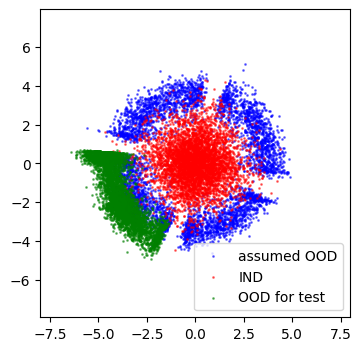

In [17]:
# after retraining, visualise IND and OOD in latent space
_, _, z_IND, _=vae(x_IND)
_, _, z_OOD, _=vae(x_OOD)
_, _, z_test_OOD, _=vae(test_OOD)
z_IND=z_IND.detach()
z_OOD=z_OOD.detach()
z_test_OOD=z_test_OOD.detach()
#plt.hist(z_OOD.flatten(),range=(-1,1),bins=100);
#plt.hist(z_IND.flatten(),range=(-1,1),bins=100);
plt.figure(figsize=(4,4))
plt.scatter(z_OOD[:,0],z_OOD[:,1],s=1,alpha=0.5,c='b',label='assumed OOD');
plt.scatter(z_IND[:,0],z_IND[:,1],s=1,alpha=0.5,c='r',label='IND');
plt.scatter(z_test_OOD[:,0],z_test_OOD[:,1],s=1,alpha=0.5,c='g',label='OOD for test');
plt.axis("equal");
plt.axis([-8,8,-8,8]);
plt.legend();
plt.savefig("Z_retrained.png",dpi=250)

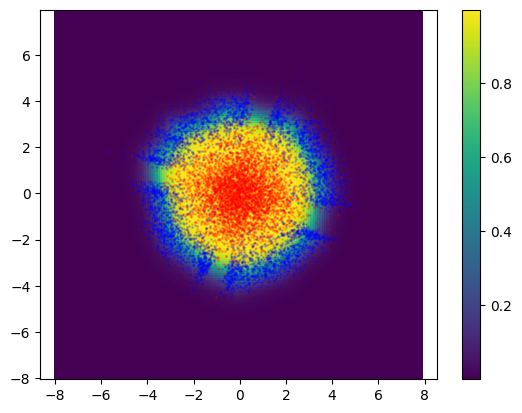

In [25]:
# visualisation and save figures
R=8
xs=torch.arange(-R,R,0.1)
ys=torch.arange(-R,R,0.1)
test_inputs=[]
for i in range(0,len(xs)):
    for j in range(0,len(ys)):
        temp=torch.zeros(data_dim)
        temp[0]=xs[i]
        temp[1]=ys[j]
        test_inputs.append(temp)
inputs=torch.stack(test_inputs)
outputs=D(inputs).detach()
plt.clf()
plt.pcolormesh(xs,ys,torch.reshape(outputs,(len(xs),len(ys))).t().numpy())
plt.colorbar()
plt.scatter(z_IND[:,0],z_IND[:,1],s=1,alpha=0.2,c='r');
plt.scatter(z_OOD[:,0],z_OOD[:,1],s=1,alpha=0.2,c='b');
#plt.scatter(x_IND_rec[:,0],x_IND_rec[:,1],s=1,alpha=0.5,c='r');
plt.axis("equal");

In [29]:
# estimate the level of the optimised KSD loss
ksds=torch.zeros(100)
for i in range(100):
    permutation=torch.randperm(len(z_OOD))[0:100]
    x_b=z_OOD[permutation,:]
    ksds[i]=KSD(x_b)
print(ksds.mean())
print( ksds.std())

tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<StdBackward0>)


In [28]:
#boundary_samples=torch.load("boundary_samples.pt")
#ksds=torch.zeros(100)
#for i in range(100):
#    permutation=torch.randperm(len(boundary_samples))[0:100]
#    x_b=boundary_samples[permutation,:]
#    ksds[i]=KSD(x_b)
#print(ksds.mean())
#print( ksds.std())

tensor(0.0273, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<StdBackward0>)
